In [2]:
import bar_chart_race as bcr
import pandas as pd
import numpy as np
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

import os
import pickle
from get_all_tickers import get_tickers

TENB_TICKERS = get_tickers.get_tickers_filtered(mktcap_min=10000)
ONEB_TICKERS = get_tickers.get_tickers_filtered(mktcap_min=1000, mktcap_max=10000)
ONEB_TECH_TICKERS = get_tickers.get_tickers_filtered(mktcap_min=1000, sectors='Technology')
TENB_TECH_TICKERS = get_tickers.get_tickers_filtered(mktcap_min=10000, sectors='Technology')
ONEB_CONSUMER_TICKERS = get_tickers.get_tickers_filtered(mktcap_min=1000, sectors='Consumer Services')
TENB_CONSUMER_TICKERS = get_tickers.get_tickers_filtered(mktcap_min=10000, sectors='Consumer Services')

In [27]:
DOW_LOWEST_DATE='2020-03-23'

HKD_RATIO=0.13
CNY_RATIO=0.15
SAR_RATIO=0.27
CHF_RATIO=1.13
KRW_RATIO=0.00092

COLUMNS=['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 
         'website', 'maxAge', 'address1', 'fax', 'industry', 'previousClose', 'regularMarketOpen', 'twoHundredDayAverage', 
         'trailingAnnualDividendYield', 'payoutRatio', 'volume24Hr', 'regularMarketDayHigh', 'navPrice', 'averageDailyVolume10Day', 
         'totalAssets', 'regularMarketPreviousClose', 'fiftyDayAverage', 'trailingAnnualDividendRate', 'open', 'averageVolume10days', 
         'expireDate', 'yield', 'algorithm', 'dividendRate', 'exDividendDate', 'beta', 'circulatingSupply', 'startDate', 
         'regularMarketDayLow', 'priceHint', 'currency', 'trailingPE', 'regularMarketVolume', 'lastMarket', 'maxSupply', 'openInterest', 
         'marketCap', 'volumeAllCurrencies', 'strikePrice', 'averageVolume', 'priceToSalesTrailing12Months', 'dayLow', 'ask', 'ytdReturn', 
         'askSize', 'volume', 'fiftyTwoWeekHigh', 'forwardPE', 'fromCurrency', 'fiveYearAvgDividendYield', 'fiftyTwoWeekLow', 'bid', 
         'tradeable', 'dividendYield', 'bidSize', 'dayHigh', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName', 
         'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'underlyingSymbol', 'quoteType', 'symbol', 
         'underlyingExchangeSymbol', 'headSymbol', 'messageBoardId', 'uuid', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue', 
         'beta3Year', 'profitMargins', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'forwardEps', 'revenueQuarterlyGrowth', 
         'sharesOutstanding', 'fundInceptionDate', 'annualReportExpenseRatio', 'bookValue', 'sharesShort', 'sharesPercentSharesOut', 
         'fundFamily', 'lastFiscalYearEnd', 'heldPercentInstitutions', 'netIncomeToCommon', 'trailingEps', 'lastDividendValue', 
         'SandP52WeekChange', 'priceToBook', 'heldPercentInsiders', 'nextFiscalYearEnd', 'mostRecentQuarter', 'shortRatio', 
         'sharesShortPreviousMonthDate', 'floatShares', 'enterpriseValue', 'threeYearAverageReturn', 'lastSplitDate', 'lastSplitFactor', 
         'legalType', 'morningStarOverallRating', 'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio', 'lastCapGain', 
         'shortPercentOfFloat', 'sharesShortPriorMonth', 'category', 'fiveYearAverageReturn', 'regularMarketPrice', 'logo_url']

TOP_TICKERS = {
    'Apple': 'AAPL',
    'Saudi Arabian Oil': dict(name='2222.SR', ratio=SAR_RATIO),
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Google': 'GOOG',
    'Facebook': 'FB',
    'Tesla': 'TSLA',
    'Alibaba': 'BABA',
    'Tencent': dict(name='0700.HK', ratio=HKD_RATIO),
    'Berkshire Hathaway': 'BRK-B',
    'Visa': 'V',
    'Tai Ji Dian': 'TSM',
    'Walmart': 'WMT',
    'Johnson & Johnson': 'JNJ',
    'JPMorgan Chase': 'JPM',
    'Mastercard': 'MA',
    'P&G': 'PG',
    'Unitedhealth Group': 'UNH',
    'Disney': 'DIS',
    'Nvidia': 'NVDA',
    'Home Depot': 'HD',
    'Meituan': dict(name='3690.HK', ratio=HKD_RATIO),
    'ICBC': dict(name='1398.HK', ratio=HKD_RATIO),
    'Maotai': dict(name='600519.SS', ratio=CNY_RATIO),
    'Nestle': dict(name='NESN.SW', ratio=CHF_RATIO),
    'Roche Holding': dict(name='ROG.SW', ratio=CHF_RATIO),
    'Samsung': dict(name='005930.KS', ratio=KRW_RATIO),
}

FOLLOWED_TICKERS = ['AMZN', 'BILI', 'PDD', 'NIO', 'LI', 'XPEV', 'BTC-USD', 'GBTC', 'ETH-USD', 'ETHE', 'NET', 'UBER',
                    'PTON', 'ONEW', '9618.HK', 'TSLA', 'BABA', '0700.HK', 'DIS', 'NVDA', '3690.HK', '600519.SS']


def get_ticker_history(ticker, period='1y', interval='1d', ratio=1):
    t = yf.Ticker(ticker)
    info = t.info
    volumes = info['marketCap'] / info['previousClose']
    df = t.history(period=period, interval=interval)
    df['MarketCap'] = df['Close'] * volumes * ratio
    return df

def get_sp500_stocks(name='sp500'):
    all_df = pd.DataFrame()
    filename = 'fixtures/{}.parquet.gzip'.format(name)
    if not os.path.exists(filename):
        with open('fixtures/sp500.pickle', 'rb') as f:
            tickers = pickle.load(f)
        for ticker in tickers:
            yahoo_ticker = ticker.replace('.', '-')
            print('Processing {}'.format(yahoo_ticker))
            df = get_ticker_history(yahoo_ticker)
            all_df[yahoo_ticker] = df['MarketCap']
        all_df.to_parquet(filename, compression='gzip')
        print('All stock data processed.')
    else:
        all_df = pd.read_parquet(filename)
        print('All stock data loaded.')
    return all_df

def get_all_stocks(name='all_stocks', tickers=[], baseline=DOW_LOWEST_DATE):
    all_df = pd.DataFrame()
    filename = 'fixtures/{}.parquet.gzip'.format(name)
    if not os.path.exists(filename):
        if not tickers:
            with open('fixtures/tickers.pickle', 'rb') as f:
                tickers = pickle.load(f)

        for ticker in sorted(set(tickers)):
            yahoo_ticker = ticker
            print('Processing {}'.format(yahoo_ticker))
            t = yf.Ticker(yahoo_ticker)
            df = t.history(period='1y')[baseline:].dropna()
            try:
                v = df.loc[baseline]['Close']
            except:
                continue
            all_df[yahoo_ticker] = (df['Close'] - v) / v
        all_df.to_parquet(filename, compression='gzip')
        print('All stock data processed.')
    else:
        all_df = pd.read_parquet(filename)
        print('All stock data loaded.')
    return all_df

def get_all_stock_data(start='', end=''):
    dfs = {}
    with open('fixtures/tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)

    for ticker in sorted(set(tickers)):
        yahoo_ticker = ticker.replace('.', '-')
        stock_file = 'fixtures/stocks/{}.parquet.gzip'.format(yahoo_ticker)
        if not os.path.exists(stock_file):
            print('Processing {}'.format(yahoo_ticker))
            t = yf.Ticker(yahoo_ticker)
            df = t.history(period='max')
            df.to_parquet(stock_file, compression='gzip')
        else:
            df = pd.read_parquet(stock_file)
        if start == '' and end == '':
            dfs[yahoo_ticker] = df
        elif start == '':
            dfs[yahoo_ticker] = df[:end]
        elif end == '':
            dfs[yahoo_ticker] = df[start:]
        else:
            dfs[yahoo_ticker] = df[start:end]

    return dfs

def get_stocks_by_mktcap(mktcap='10B', baseline=DOW_LOWEST_DATE):
    opts = {
        '1B': ('1b_stocks', ONEB_TICKERS),
        '10B': ('10b_stocks', TENB_TICKERS),
        '1B_TECH': ('1b_tech_stocks', ONEB_TECH_TICKERS),        
        '10B_TECH': ('10b_tech_stocks', TENB_TECH_TICKERS),
        '1B_CONSUMER': ('1b_consumer_stocks', ONEB_CONSUMER_TICKERS),        
        '10B_CONSUMER': ('10b_consumer_stocks', TENB_CONSUMER_TICKERS),         
    }
    (name, tickers) = opts[mktcap]
        
    all_df = pd.DataFrame()
    filename = 'fixtures/{}.parquet.gzip'.format(name)
    if not os.path.exists(filename):

        for ticker in sorted(set(tickers)):
            yahoo_ticker = ticker.replace('.', '-')
            print('Processing {}'.format(yahoo_ticker))
            t = yf.Ticker(yahoo_ticker)
            df = t.history(period='1y')[baseline:].dropna()
            try:
                v = df.loc[baseline]['Close']
            except:
                continue
            all_df[yahoo_ticker] = (df['Close'] - v) / v
        all_df.to_parquet(filename, compression='gzip')
        print('All stock data processed.')
    else:
        all_df = pd.read_parquet(filename)
        print('All stock data loaded.')
    return all_df    

def get_stocks(name='top_tickers', tickers=TOP_TICKERS):
    all_df = pd.DataFrame()
    filename = 'fixtures/{}.parquet.gzip'.format(name)
    if not os.path.exists(filename):
        for name, info in tickers.items():
            if type(info) == str:
                info = dict(name=info, ratio=1)
            df = get_ticker_history(info['name'], ratio=info['ratio'])
            all_df[name] = df['MarketCap'] / 1000000
            print('{} processed'.format(name))
        all_df = all_df.round(2)
        all_df.to_parquet(filename, compression='gzip')
        print('All stock data processed.')
    else:
        all_df = pd.read_parquet(filename)
        print('All stock data loaded.')
    return all_df

def get_all_stock_info(name='all_stock_info'):
    all_df = pd.DataFrame(columns=COLUMNS)
    filename = 'fixtures/{}.parquet.gzip'.format(name)
    if not os.path.exists(filename):
        with open('fixtures/tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)

        for ticker in sorted(set(tickers)):
            yahoo_ticker = ticker.replace('.', '-')
            info_file = 'fixtures/stocks/{}.pickle'.format(yahoo_ticker)
            if not os.path.exists(info_file):
                print('Processing {}'.format(yahoo_ticker))
                t = yf.Ticker(yahoo_ticker)
                try:
                    info = dict(t.info)
                except:
                    info = None
                with open(info_file, 'wb') as f:
                    pickle.dump(info, f)
            else:
                with open(info_file, 'rb') as f:
                    info = pickle.load(f)
            try:
                if info:
                    all_df.loc[yahoo_ticker] = info
                else:
                    print('Skipped ticker: {}'.format(yahoo_ticker))
            except:
                continue
        all_df.fillna(value=np.nan, inplace=True)
        all_df.to_parquet(filename, compression='gzip')
        print('All stock data processed.')
    else:
        all_df = pd.read_parquet(filename)
        print('All stock data loaded.')
    return all_df

In [25]:
FIG_ARGS=dict(figsize=(16,9), dpi=200)

In [26]:
df = get_stocks()
bcr.bar_chart_race(df=df.drop(columns=['Saudi Arabian Oil']), n_bars=20, title='Top 20 Companies by Market Cap',
                   bar_textposition='inside',
                   filter_column_colors=True, fig_kwargs=FIG_ARGS, filename='videos/stock.mp4') 

In [35]:
df = get_all_stocks()
df = df.drop(columns=df.columns[((df > 30).mean() > 0)], axis=1)
df = df['2020-03-24':]
bcr.bar_chart_race(df=df, n_bars=20, title='Top 20 Companies by Return after Covid19 Market Crash',
                   bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   filter_column_colors=True, fig_kwargs=FIG_ARGS, filename='videos/stock_growth.mp4') 

All stock data loaded.


In [36]:
df = get_stocks_by_mktcap('10B')
bcr.bar_chart_race(df=df['2020-03-24':], n_bars=20, title='Top 20 Companies (mktCap > 10B) by Return after Covid19 Market Crash',
                   bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   filter_column_colors=True, fig_kwargs=FIG_ARGS, filename='videos/stock_10b_growth.mp4') 

All stock data loaded.


In [37]:
df = get_stocks_by_mktcap('1B')
bcr.bar_chart_race(df=df['2020-03-24':], n_bars=20, title='Top 20 Companies (1B < mktCap < 10B) by Return after Covid19 Market Crash',
                   bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   filter_column_colors=True, fig_kwargs=FIG_ARGS, filename='videos/stock_1b_growth.mp4') 

All stock data loaded.


In [38]:
df = get_stocks_by_mktcap('1B_TECH')
bcr.bar_chart_race(df=df['2020-03-24':], n_bars=20, title='Top 20 Tech Companies (mktCap > 1B) by Return after Covid19 Market Crash', 
                   filter_column_colors=True, bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   fig_kwargs=FIG_ARGS, filename='videos/stock_1b_tech_growth.mp4') 

All stock data loaded.


In [39]:
df = get_stocks_by_mktcap('10B_TECH')
bcr.bar_chart_race(df=df['2020-03-24':], n_bars=20, title='Top 20 Tech Companies (mktCap > 10B) by Return after Covid19 Market Crash', 
                   filter_column_colors=True, bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   fig_kwargs=FIG_ARGS, filename='videos/stock_10b_tech_growth.mp4') 

All stock data loaded.


In [7]:
df = get_stocks_by_mktcap('1B_CONSUMER')
bcr.bar_chart_race(df=df['2020-03-24':], n_bars=20, title='Top 20 Consumer Companies (mktCap > 1B) by Return after Covid19 Market Crash', 
                   filter_column_colors=True, bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   fig_kwargs=FIG_ARGS, filename='videos/stock_1b_consumer_growth.mp4')

In [ ]:
df = get_stocks_by_mktcap('10B_CONSUMER')
bcr.bar_chart_race(df=df['2020-03-24':], n_bars=20, title='Top 20 Consumer Companies (mktCap > 10B) by Return after Covid19 Market Crash', 
                   filter_column_colors=True, bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   fig_kwargs=FIG_ARGS, filename='videos/stock_10b_consumer_growth.mp4')

In [23]:
df = get_all_stocks('followed_stocks', FOLLOWED_TICKERS)
bcr.bar_chart_race(df=df['2020-03-24':].fillna(method='ffill'), n_bars=20, title='My followed stocks by Return after Covid19 Market Crash',
                   bar_textposition='inside', bar_texttemplate='{x:,.2%}', tick_template='{x:,.2%}',
                   filter_column_colors=True, fig_kwargs=FIG_ARGS, filename='videos/followed_stock_growth.mp4') 

All stock data loaded.


In [36]:
df = get_all_stock_info()
df

All stock data loaded.


,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,state,country,companyOfficers,website,...,earningsQuarterlyGrowth,dateShortInterest,pegRatio,lastCapGain,shortPercentOfFloat,sharesShortPriorMonth,category,fiveYearAverageReturn,regularMarketPrice,logo_url
index,,,,,,,,,,,,,,,,,,,,,
A,95051,Healthcare,16400.0,"Agilent Technologies, Inc. provides applicatio...",Santa Clara,800 227 9770,CA,United States,[],http://www.agilent.com,...,0.144,1.607990e+09,3.42,NaN,0.0105,3092340.0,None,NaN,117.86,https://logo.clearbit.com/agilent.com
AA,15212,Basic Materials,13800.0,"Alcoa Corporation, together with its subsidiar...",Pittsburgh,412-315-2900,PA,United States,[],http://www.alcoa.com,...,NaN,1.607990e+09,-0.06,NaN,0.0598,9765144.0,None,NaN,22.07,https://logo.clearbit.com/alcoa.com
AACG,100022,Consumer Defensive,768.0,"ATA Creativity Global, together with its subsi...",Beijing,86 10 6518 1133,None,China,[],http://www.atai.net.cn,...,NaN,1.607990e+09,NaN,NaN,NaN,4511.0,None,NaN,1.17,https://logo.clearbit.com/atai.net.cn
AACQ,10019,Financial Services,NaN,Artius Acquisition Inc. focuses on effecting a...,New York,212 309 7668,NY,United States,[],None,...,NaN,1.607990e+09,NaN,NaN,NaN,22524.0,None,NaN,10.52,
AAIC,22209,Real Estate,11.0,Arlington Asset Investment Corp. (NYSE: AI) is...,Arlington,703-373-0200,VA,United States,[],http://www.arlingtonasset.com,...,NaN,1.607990e+09,-0.40,NaN,0.0287,749339.0,None,NaN,3.76,https://logo.clearbit.com/arlingtonasset.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUMZ,98036,Consumer Cyclical,2575.0,"Zumiez Inc., together with its subsidiaries, o...",Lynnwood,425 551 1500,WA,United States,[],http://www.zumiez.com,...,0.519,1.607990e+09,0.83,NaN,0.0546,1201881.0,None,NaN,36.50,https://logo.clearbit.com/zumiez.com
ZUO,94065,Technology,1249.0,"Zuora, Inc. provides cloud-based software on a...",Redwood City,888-976-9056,CA,United States,[],http://www.zuora.com,...,NaN,1.607990e+09,NaN,NaN,0.0574,7650391.0,None,NaN,13.89,https://logo.clearbit.com/zuora.com
ZVO,85286,Consumer Defensive,1830.0,Zovio Inc operates as an education technology ...,Chandler,858 668 2586,AZ,United States,[],http://www.zovio.com,...,NaN,1.607990e+09,1.19,NaN,0.0417,930229.0,None,NaN,4.17,https://logo.clearbit.com/zovio.com


In [37]:
df1 = df.groupby('city').sum()
s1 = df1['marketCap'] / 1000000000
s2 = df1['fullTimeEmployees']
df2 = pd.DataFrame({'marketCap': s1, 'Employees': s2})
df2.sort_values(by=['marketCap'], ascending=False)[:30]

,marketCap,Employees
city,,
New York,3265.587270,2319086.0
Mountain View,2524.454072,300160.0
Cupertino,2290.706467,147263.0
Seattle,1977.528622,1649369.0
San Francisco,1974.021796,709966.0
Redmond,1682.012494,163119.0
San Jose,1320.750940,346725.0
Atlanta,1083.729498,1208661.0
London,974.906014,1303487.0


In [63]:
import mplfinance as mpf

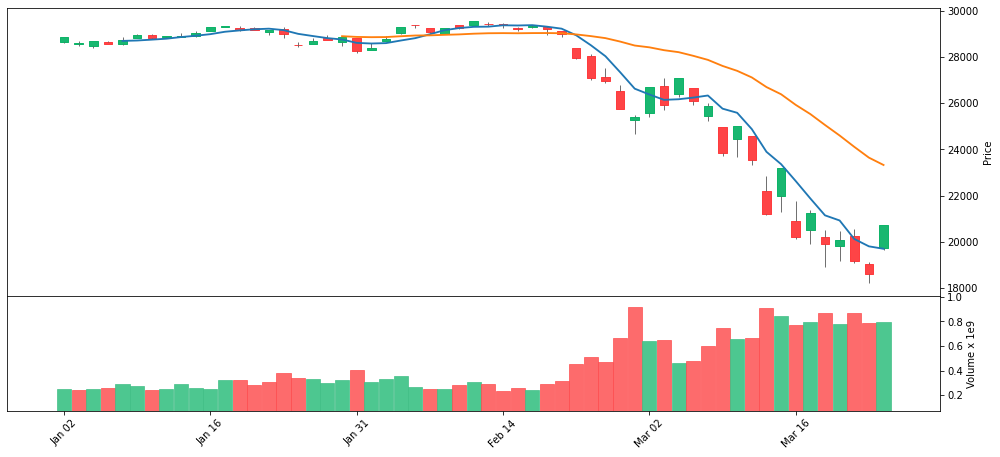

In [64]:
dow = yf.Ticker('^DJI')
df = dow.history(period='max')['2020-01-01':'2020-03-24']
mpf.plot(df, type='candle', style='yahoo', mav=(5,20,60), volume=True, figsize=(18, 8))

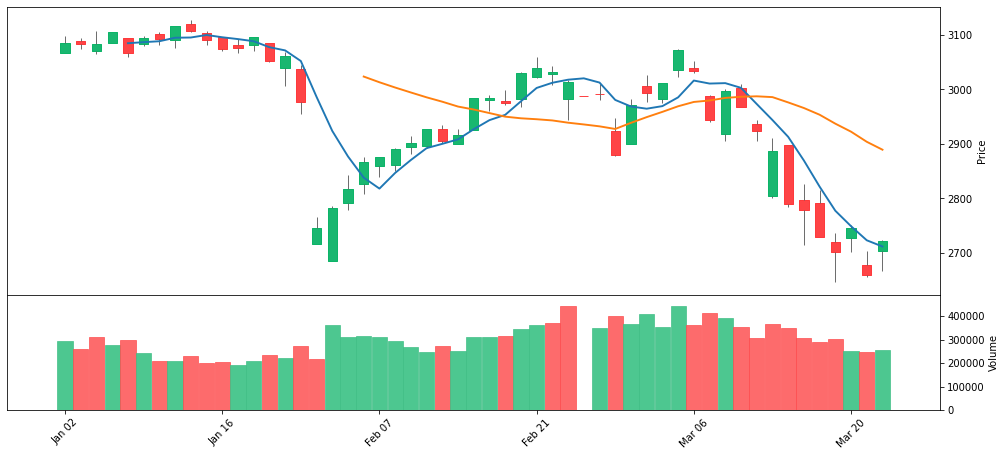

In [65]:
ss = yf.Ticker('000001.SS')
df = ss.history(period='max')['2020-01-01':'2020-03-24']
mpf.plot(df, type='candle', style='yahoo', mav=(5,20,60), volume=True, figsize=(18, 8))

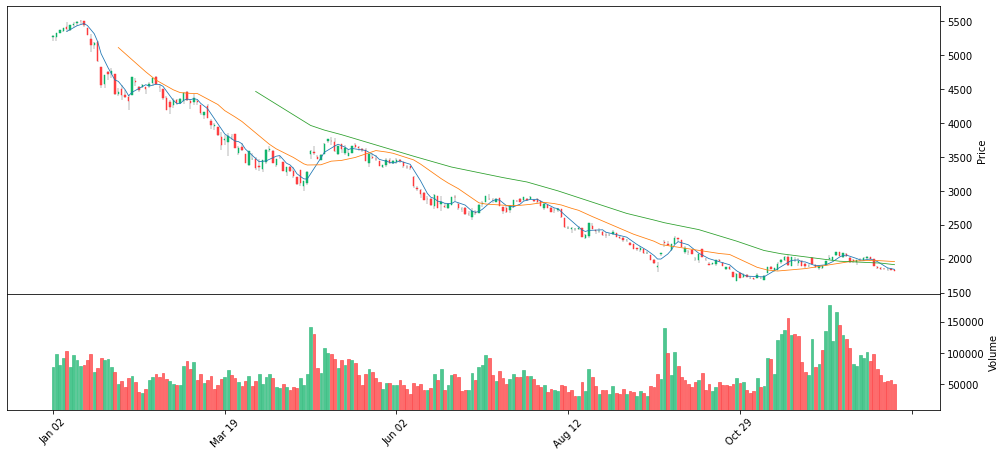

In [66]:
ss = yf.Ticker('000001.SS')
df = ss.history(period='max')['2008-01-01':'2008-12-31']
mpf.plot(df, type='candle', style='yahoo', mav=(5,20,60), volume=True, figsize=(18, 8))